## Variance inflation factor (VIF) and explainability

- https://www.kaggle.com/code/carlmcbrideellis/variance-inflation-factor-vif-and-explainability

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

데이터 과학의 근본적인 부분은 설명 가능성이며, 무슨 일이 일어나고 있는지 파악하려면 선형 회귀를 수행하는 것보다 더 좋은 방법은 없습니다. 그러나 몇 가지 기본적인 예방 조치를 취하지 않으면 상관관계라는 문제에 걸려들 수 있습니다. 선형 회귀는 모든 특징이 서로 독립적(직교)일 때 가장 이상적으로 작동하지만, 항상 그런 것은 아닙니다(즉, 거의 절대 아닙니다).

여기서는 이변량 상관관계가 있는 매우 간단한 예를 만들겠습니다. 여기서 '실측값'은 단순히 시속 마일(mph)의 속도와 관련하여 소비된 연료가 될 것입니다.
연료 소비량=1 × mph
 
이 데이터에 여전히 속도 이지만, 이제 시속 킬로미터(kmph)로 변환된 피처를 추가합니다.  
또한 직교하지만 전혀 쓸모가 없는 두 개의 기능, 즉 난수 열과 하이드 파크에서 한 번에 풀을 뜯는 유니콘의 수를 나타내는 열을 추가합니다.

In [2]:
from numpy.random import default_rng

In [3]:
rng = default_rng()
# set the RNG seed in case we wish to test the stability of our predictions
np.random.seed(8)

In [4]:
df               = pd.DataFrame(np.arange(0,100,0.5), columns=["mph"])
df['kmph']       = df['mph'] * 1.609344
df['n_unicorns'] = np.random.randint(low= 1, high=  4, size=df.shape[0])
df['RNG']        = np.random.uniform(low= 0, high= 50, size=df.shape[0])
# we shall also add a little Gaussian noise to the target
df['fuel']       = df['mph'] * (1 + np.random.normal(0,0.02, size=df.shape[0]))
X = df.iloc[:,[0,1,2,3]]
y = df.iloc[:,[4]]
# take a look
df

,mph,kmph,n_unicorns,RNG,fuel
0,0.0,0.000000,1,18.378527,0.000000
1,0.5,0.804672,2,12.032513,0.490364
2,1.0,1.609344,2,2.411589,0.997131
3,1.5,2.414016,2,8.758339,1.513638
4,2.0,3.218688,3,27.838772,1.961464
...,...,...,...,...,...
195,97.5,156.911040,2,13.968118,95.976657
196,98.0,157.715712,3,48.608956,98.747284
197,98.5,158.520384,1,16.558214,99.661694
198,99.0,159.325056,3,48.056735,100.566006


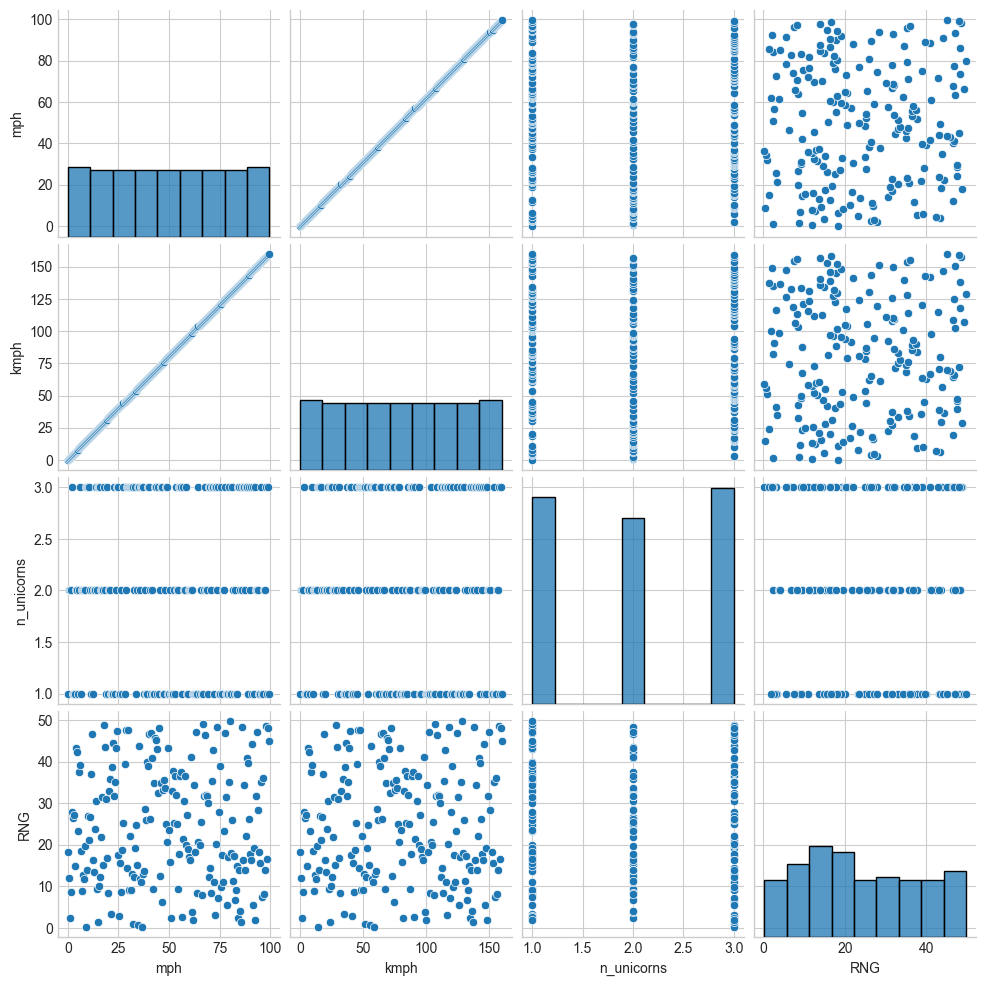

In [5]:
sns.pairplot(X)

In [6]:
from sklearn import linear_model

regression = linear_model.LinearRegression()


regression.fit(df.iloc[:, [0]], df.iloc[:, [4]])
print("Ground truth regression coefficient:",regression.coef_)

Ground truth regression coefficient: [[0.99984436]]


In [7]:
# full regression using statsmodels

import statsmodels.api as sm

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                   fuel   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.604e+05
Date:                Wed, 19 Jul 2023   Prob (F-statistic):                        0.00
Time:                        14:52:50   Log-Likelihood:                         -314.18
No. Observations:                 200   AIC:                                      634.4
Df Residuals:                     197   BIC:                                      644.3
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

full regression에서 계산식은 다음과 같이 되었다.  

fuel=0.2786 mph+0.4483 kmph

### VIF

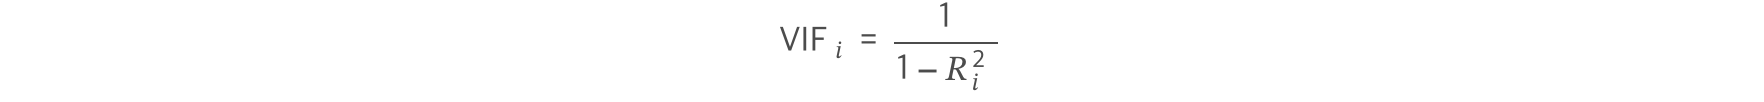

일반적으로 VIF 5 이상이면 다른 피처와 높은 다중공선성을 보인다고 간주한다.

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

VIF             = pd.DataFrame()
VIF['feature']  = X.columns
VIF['VIF']      = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# take a look
VIF

,feature,VIF
0,mph,inf
1,kmph,inf
2,n_unicorns,3.507853
3,RNG,2.986786


- mph and kmph는 매우 높은 것으로 확인됨

kmph를 삭제하고 진행해보자.

In [9]:
X = X.drop('kmph', axis = 1)

VIF            = pd.DataFrame()
VIF['feature'] = X.columns
VIF['VIF']     = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
VIF

,feature,VIF
0,mph,3.054533
1,n_unicorns,3.507853
2,RNG,2.986786


- 이제 모든 VIF가 5 이하가 되었다.

In [10]:
results = sm.OLS(y, X).fit()
print(results.summary()) 

                                 OLS Regression Results                                
Dep. Variable:                   fuel   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.604e+05
Date:                Wed, 19 Jul 2023   Prob (F-statistic):                        0.00
Time:                        14:52:50   Log-Likelihood:                         -314.18
No. Observations:                 200   AIC:                                      634.4
Df Residuals:                     197   BIC:                                      644.3
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Zero variance columns

분산이 0인 컬럼도 제거하는 것이 좋다.  
컬럼의 값이 일정하면 타겟에 영향을 미치지 않는다.   
이러한 컬럼 제거를 위해 VarianceThreshold를 사용하면된다.